In [1]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap

from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from experiment1 import Autoencoder, to_img

torch.manual_seed(42)

In [2]:
batch_size = 32

# Load data
img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

dataset = MNIST('../data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load model
model = Autoencoder()
top_model_state = torch.load('../trained_models/experiment1.pth')
vanilla_model_state = torch.load('../examples/conv_autoencoder.pth')


In [3]:
def get_latent_space(model, model_state, dataloader):
    model.load_state_dict(model_state)
    
    #ensure that seed is correct (despite several function calls)
    torch.manual_seed(42)
    
    full_latent_space = []
    all_labels = []

    for index, batch in enumerate(dataloader):
        image, label = batch
        latent, reconst = model(image)
        latent = latent.detach().numpy()
        reconst = reconst.detach().numpy()

        full_latent_space.append(latent)
        all_labels.append(label)

        #if index == 199:
        #    break

    full_latent_space = np.concatenate(full_latent_space, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return [full_latent_space, all_labels]

In [4]:
top_latent_space, top_labels = get_latent_space(model, top_model_state, dataloader)
vanilla_latent_space, van_labels = get_latent_space(model, vanilla_model_state, dataloader)

In [5]:
#Extract full data space for baseline t-sne:
full_data_space = []
all_labels = []
torch.manual_seed(42)
for index, batch in enumerate(dataloader):
    image, label = batch
    im = image.detach().numpy()
    im_flat = im.reshape(-1, im.shape[0]).T
    full_data_space.append(im_flat)
    all_labels.append(label)
    #if index == 50:
    #    break
    
full_data_space = np.concatenate(full_data_space, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [14]:
full_latent_space.shape

(60000, 32)

In [6]:
n_samples = 10000

In [86]:
tsne = TSNE(random_state=42, perplexity=20)
Z_tsne_top = tsne.fit_transform(top_latent_space[:n_samples,:]) # full_data_space

tsne = TSNE(random_state=42, perplexity=20)
Z_tsne_van = tsne.fit_transform(vanilla_latent_space[:n_samples,:])


In [ ]:
mds = MDS(n_components=2)
Z_mds_top = mds.fit_transform(top_latent_space[:n_samples,:])
mds = MDS(n_components=2)
Z_mds_van = mds.fit_transform(vanilla_latent_space[:n_samples,:])

In [ ]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(full_data_space[:n_samples,:])

In [ ]:
isomap = Isomap(n_components=2)
Z_isomap = isomap.fit_transform(X[:100])

In [27]:
kpca = KernelPCA(kernel="rbf", gamma=1)
Z_kpca = kpca.fit_transform(full_latent_space[:n_samples,:])



In [79]:
pca = PCA()
Z_pca_top = pca.fit_transform(top_latent_space[:n_samples,:])
pca = PCA()
Z_pca_van = pca.fit_transform(vanilla_latent_space[:n_samples,:])
pca = PCA()
X_pca = pca.fit_transform(full_data_space[:n_samples,:])

In [ ]:
def plotting(transformed, all_labels, title):
    color_mapping = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
    distinct_labels = np.unique(all_labels)
    colors = [color_mapping[cl] for cl in distinct_labels]
    for i, label in enumerate(distinct_labels):
        mask = (all_labels == label).astype(int)
        inds = list(np.where(mask)[0])
        plt.scatter(transformed[inds, 0], transformed[inds, 1], c=[colors[i]], label=label, s=1)
    plt.title(title)
    lgnd = plt.legend(loc="lower left")
    for i,_ in enumerate(distinct_labels):
        lgnd.legendHandles[i]._sizes = [30]

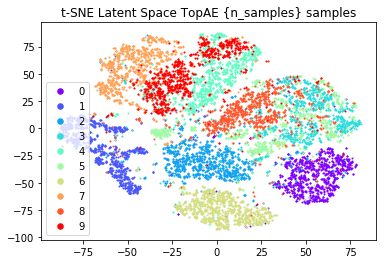

In [89]:
plotting(Z_tsne_top, top_labels[:n_samples], 't-SNE Latent Space TopAE {n_samples} samples')

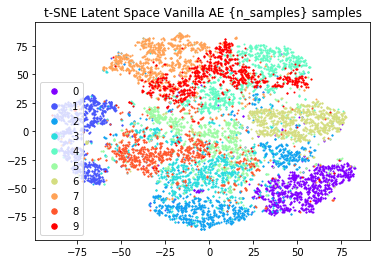

In [90]:
plotting(Z_tsne_van, van_labels[:n_samples], 't-SNE Latent Space Vanilla AE {n_samples} samples')

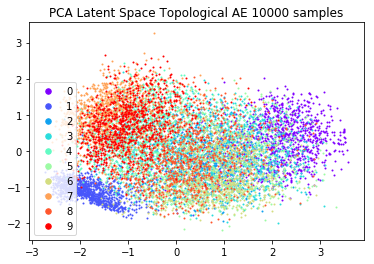

In [80]:
plotting(Z_pca_top, top_labels[:n_samples], f'PCA Latent Space Topological AE {n_samples} samples')

In [ ]:
plotting(Z_pca_van, van_labels[:n_samples], f'PCA Latent Space Vanilla AE {n_samples} samples')

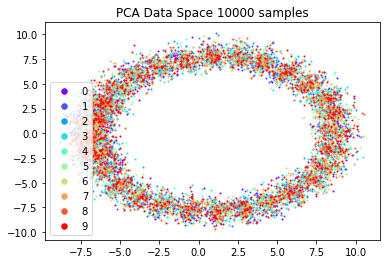

In [82]:
plotting(X_pca, all_labels[:n_samples], f'PCA Data Space {n_samples} samples')

In [ ]:
plotting(Z_mds_top, top_labels[:n_samples], f'MDS Latent Space Topological AE {n_samples} samples')

In [ ]:
plotting(Z_mds_van, van_labels[:n_samples], f'MDS Latent Space Vanilla AE {n_samples} samples')

In [ ]:
plotting(X_mds, all_labels[:n_samples], f'MDS Data Space {n_samples} samples')